In [1]:
import numpy as np
import pandas as pd
import math, os, time, tqdm
import datetime as dt
import matplotlib.pyplot as plt

### Market DataSet

In [2]:
market_quotes = pd.read_csv('rates_20240710.csv')
market_quotes['date'] = pd.to_datetime(market_quotes['date'], format = '%Y-%m-%d')
#market_quotes.drop(index=market_quotes.index[:4301], axis=0, inplace=True) #Drop all dates with Nan-values, starting at 2020-11-02
#market_quotes = market_quotes.reset_index(drop=True) 

market_quotes.set_index('date', inplace = True)

In [3]:
sonia_tenors = ['sonia1m', 'sonia3m', 'sonia6m', 'sonia1y', 'sonia2y', 'sonia3y', 'sonia4y', 'sonia5y', 'sonia7y', 'sonia10y', 'sonia30y']
estr_tenors = ['estr1m', 'estr3m', 'estr6m', 'estr1y', 'estr2y', 'estr3y', 'estr4y', 'estr5y', 'estr7y', 'estr10y', 'estr30y']
sofr_tenors = ['sofr1m', 'sofr3m', 'sofr6m', 'sofr1y', 'sofr2y', 'sofr3y', 'sofr4y', 'sofr5y', 'sofr7y', 'sofr10y', 'sofr30y']
euribor_tenors = ['eur1m', 'eur3m', 'eur6m', 'eur1y', 'eur2y', 'eur3y', 'eur4y', 'eur5y', 'eur7y', 'eur10y', 'eur30y']

sonia = market_quotes[sonia_tenors]
estr = market_quotes[estr_tenors]
sofr = market_quotes[sofr_tenors]
euribor = market_quotes[euribor_tenors]

<Axes: title={'center': 'ESTR'}, xlabel='date'>

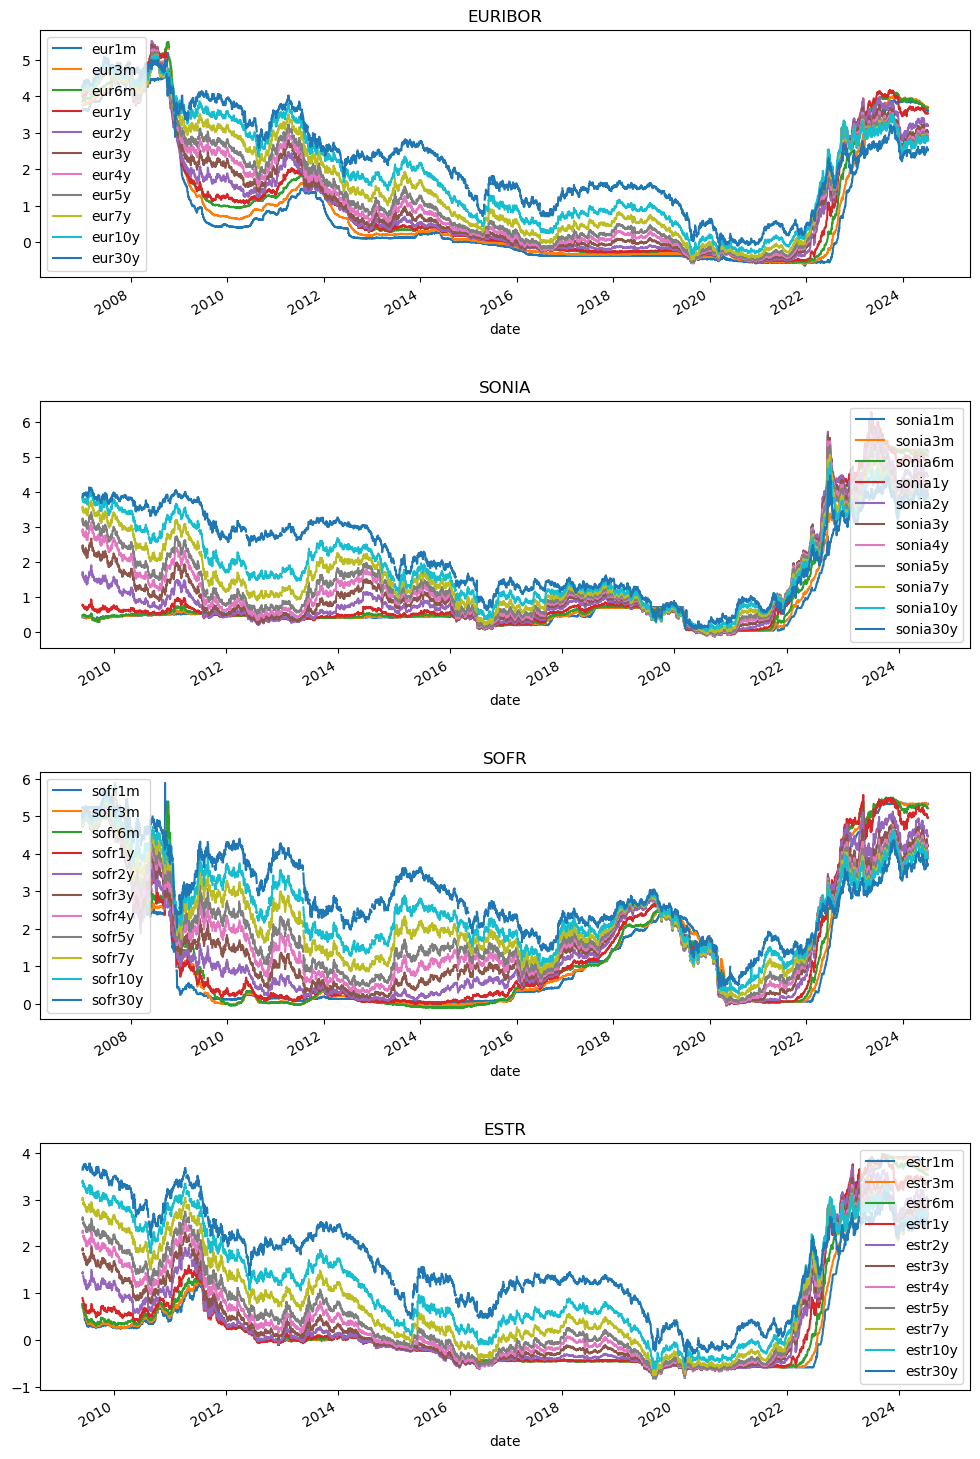

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize = [12, 20])

plt.subplots_adjust(hspace = 0.5)

euribor.plot(ax=axes[0], title = 'EURIBOR', rot = 30)
sonia.plot(ax=axes[1], title = 'SONIA')
sofr.plot(ax=axes[2], title = 'SOFR')
estr.plot(ax=axes[3], title = 'ESTR')

### PCA of Yield Curve, EURIBOR

In [5]:
print(euribor.shape)

euribor = euribor.dropna(axis=0)
print(euribor.shape)

(5260, 11)
(4543, 11)


Daily changes $\Delta t = \dfrac{1}{360}$ of Yield Curve $\mathbf{x_i}(t) = y(t + \Delta t, \; t + \Delta t + \tau_i) - y(t, \; t + \tau_i)$

EURIBOR for $n = 11$ time-to-maturities $\tau_i = 1m, \; 3m, \; 6m, \; 1y, \; 2y, \; 3y, \; 4y, \; 5y, \; 7y, \; 10y, \; 30y$

In [6]:
#scm = X.cov()
scm = euribor.cov()
D, Q = np.linalg.eig(scm)
Q = -Q
print(f'Contribution to Variation of Returns-data from largest Principal Component is {D[0] / np.sum(D)}')
print(f'Contribution to Variation of Returns-data from 2nd Principal Component is {D[1] / np.sum(D)}')
print(f'Contribution to Variation of Returns-data from 3rd Principal Component is {D[2] / np.sum(D)}')
print(scm.shape)

Contribution to Variation of Returns-data from largest Principal Component is 0.9467810683204063
Contribution to Variation of Returns-data from 2nd Principal Component is 0.04506196343244431
Contribution to Variation of Returns-data from 3rd Principal Component is 0.00687322154460156
(11, 11)


The first 3 Principal Components explain 0.9987162532974522 of the Variance


Text(0.5, 1.0, 'EURIBOR SCM')

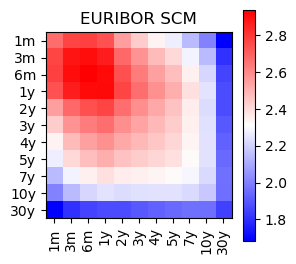

In [7]:
print(f'The first 3 Principal Components explain {(D[0] + D[1] + D[2]) / np.sum(D)} of the Variance')

import matplotlib.colors as mcolors

f = plt.figure(figsize=(3, 3))
plt.ion()
plt.set_cmap('bwr')

c_max = scm.to_numpy().max()
c_min = scm.to_numpy().min()
norm = mcolors.TwoSlopeNorm(vmin = c_min, vcenter = (c_max + c_min) / 2, vmax = c_max)
before = plt.imshow(scm, interpolation = "none", norm = norm)
plt.xticks(ticks=np.arange(11), 
           labels=['1m', '3m', '6m', '1y', '2y', '3y', '4y', '5y', '7y', '10y', '30y'], 
           rotation=90, fontsize = 10)
plt.yticks(ticks=np.arange(11), 
           labels=['1m', '3m', '6m', '1y', '2y', '3y', '4y', '5y', '7y', '10y', '30y'], 
           rotation=0, fontsize = 10)
cbar = f.colorbar(before)
plt.title("EURIBOR SCM")

The first 3 Principal Components explain 0.9987162532974522 of the Variance


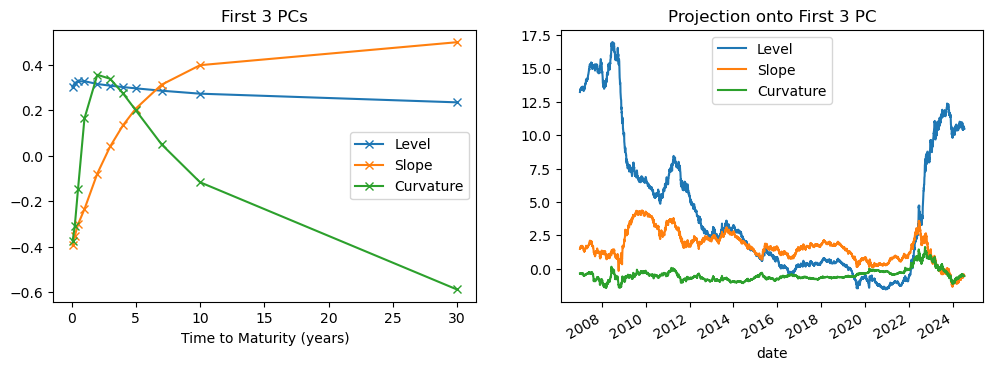

In [8]:
print(f'The first 3 Principal Components explain {(D[0] + D[1] + D[2]) / np.sum(D)} of the Variance')

label = ['Level', 'Slope', 'Curvature']

tenors = [1 / 12, 0.25, 0.5, 1, 2, 3, 4, 5, 7, 10, 30]

fig = plt.figure(figsize = [12,4])
ax1 = fig.add_subplot(121)
ax1.plot(tenors, Q[:, :3], 'x-')
plt.xlabel('Time to Maturity (years)')
ax1.legend(label, loc = 'best')
plt.title('First 3 PCs')

#Projecting onto first 3 PC
z = euribor.dot(Q).iloc[:, :3]

ax2 = fig.add_subplot(122)
z.plot(ax = ax2, title = 'Projection onto First 3 PC')
ax2.legend(label, loc = 'best')


### PCA of Yield Curve, SOFR

In [9]:
print(sofr.shape)

sofr = sofr.dropna(axis=0)
print(sofr.shape)

(5260, 11)
(4543, 11)


Daily changes $\Delta t = \dfrac{1}{360}$ of Yield Curve $\mathbf{x_i}(t) = y(t + \Delta t, \; t + \Delta t + \tau_i) - y(t, \; t + \tau_i)$

SOFR for $n = 11$ time-to-maturities $\tau_i = 1m, \; 3m, \; 6m, \; 1y, \; 2y, \; 3y, \; 4y, \; 5y, \; 7y, \; 10y, \; 30y$

In [10]:
#scm = X.cov()
scm = sofr.cov()
D, Q = np.linalg.eig(scm)
print(f'Contribution to Variation of Returns-data from largest Principal Component is {D[0] / np.sum(D)}')
print(f'Contribution to Variation of Returns-data from 2nd Principal Component is {D[1] / np.sum(D)}')
print(f'Contribution to Variation of Returns-data from 3rd Principal Component is {D[2] / np.sum(D)}')
print(scm.shape)

Contribution to Variation of Returns-data from largest Principal Component is 0.9086061884338598
Contribution to Variation of Returns-data from 2nd Principal Component is 0.0772947988786654
Contribution to Variation of Returns-data from 3rd Principal Component is 0.011013955275962195
(11, 11)


Text(0.5, 1.0, 'SOFR SCM')

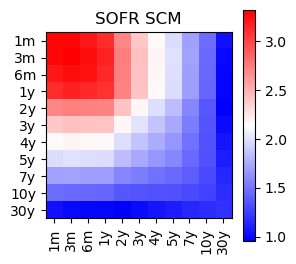

In [11]:
f = plt.figure(figsize=(3, 3))
plt.ion()
plt.set_cmap('bwr')

c_max = scm.to_numpy().max()
c_min = scm.to_numpy().min()
norm = mcolors.TwoSlopeNorm(vmin = c_min, vcenter = (c_max + c_min) / 2, vmax = c_max)
before = plt.imshow(scm, interpolation="none", norm = norm)
plt.xticks(ticks=np.arange(11), 
           labels=['1m', '3m', '6m', '1y', '2y', '3y', '4y', '5y', '7y', '10y', '30y'], 
           rotation=90, fontsize = 10)
plt.yticks(ticks=np.arange(11), 
           labels=['1m', '3m', '6m', '1y', '2y', '3y', '4y', '5y', '7y', '10y', '30y'], 
           rotation=0, fontsize = 10)
cbar = f.colorbar(before)
plt.title("SOFR SCM")

The first 3 Principal Components explain 0.9969149425884872 of the Variance


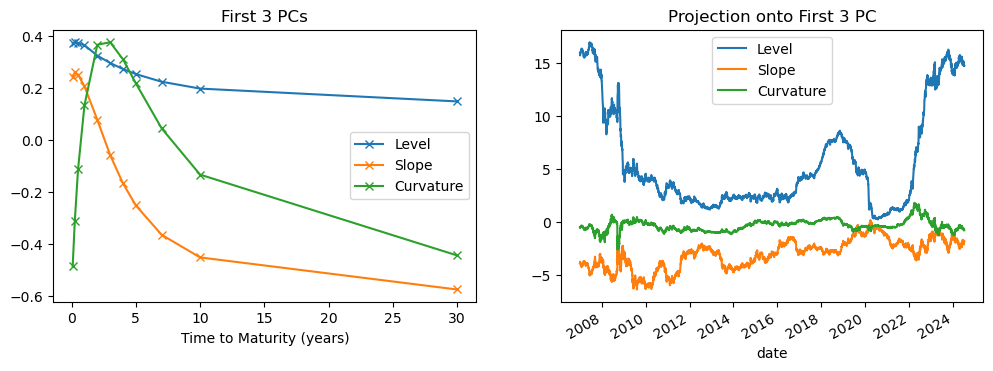

In [12]:
print(f'The first 3 Principal Components explain {(D[0] + D[1] + D[2]) / np.sum(D)} of the Variance')

label = ['Level', 'Slope', 'Curvature']

tenors = [1 / 12, 0.25, 0.5, 1, 2, 3, 4, 5, 7, 10, 30]

fig = plt.figure(figsize = [12,4])
ax1 = fig.add_subplot(121)
ax1.plot(tenors, Q[:, :3], 'x-')
plt.xlabel('Time to Maturity (years)')
ax1.legend(label, loc = 'best')
plt.title('First 3 PCs')

#Projecting onto first 3 PC
z = sofr.dot(Q).iloc[:, :3]

ax2 = fig.add_subplot(122)
z.plot(ax = ax2, title = 'Projection onto First 3 PC')
ax2.legend(label, loc = 'best')
